## TESS light curve fit for TOI562.1 (GJ357b)
Example of using some of the [lmfit](https://lmfit.github.io/lmfit-py/) Model classes in pycheops.models to fit the TESS light curve for a planet candidate orbiting an M-dwarf

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astroquery.mast import Observations
from astropy.table import Table, Column
from pycheops import models
from pycheops.ld import stagger_power2_interpolator
from uncertainties import UFloat, ufloat
from emcee import EnsembleSampler
import celerite2
from pycheops.utils import phaser, lcbin
from celerite2 import terms
from scipy.optimize import minimize
from astropy.time import Time
from pycheops.funcs import transit_width
from pycheops.starproperties import StarProperties
from lmfit import Parameter
import warnings

#### Target information
Taken from DVM Data summary report

In [2]:
TIC = 413248763 
T0 = 1517.9997  # Time of mid-transit, BJD-2457000
P = 3.93079     # Orbital period, days
k = 0.0333      # Rp/Rs, planet-star radius ratio
aR = 17.49       # a/Rs, semi-major axis/star radius 
b = 0.68        # Impact parameter

#### Download TESS data

In [3]:
flux_column = 'PDCSAP_FLUX'
# flux_column = 'SAP_FLUX'
#quality_bitmask=1130799  # "default": cadences with severe quality issues will be ignored
quality_bitmask=1664431 #  more conservative choice of flags to ignore - this is known to remove good data.

tjd = np.array([])
flux = np.array([])
sector = np.array([])
nsec = 0
for obs in Observations.query_criteria(target_name=TIC,
                                       obs_collection=["TESS"],
                                       provenance_name='SPOC',
                                       t_exptime=[60.,180.]):
    print(obs['obs_id'],obs['sequence_number'])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        obslist = Observations.get_product_list(obs['obsid'])
        m=Observations.download_products(obslist[obslist['description'] == "Light curves"])
        if m is not None:
            data = Table.read(m['Local Path'][0])
        iok = ( ((data['QUALITY'] & quality_bitmask) == 0) &
                np.isfinite(data['PDCSAP_FLUX'])).nonzero()
        data = data[iok]
        tjd=np.append(tjd,np.array(data['TIME']))  
        flx=np.array(data[flux_column])
        flux=np.append(flux,flx/np.median(flx))
        sector=np.append(sector,np.full_like(flx,obs['sequence_number']))
        nsec += 1


tess2021039152502-s0035-0000000413248763-0205-s 35
INFO: Found cached file ./mastDownload/TESS/tess2021039152502-s0035-0000000413248763-0205-s/tess2021039152502-s0035-0000000413248763-0205-s_lc.fits with expected size 1828800. [astroquery.query]
tess2018206190142-s0001-s0036-0000000413248763 36
tess2019032160000-s0008-0000000413248763-0136-s 8
INFO: Found cached file ./mastDownload/TESS/tess2019032160000-s0008-0000000413248763-0136-s/tess2019032160000-s0008-0000000413248763-0136-s_lc.fits with expected size 1805760. [astroquery.query]
tess2023043185947-s0062-0000000413248763-0254-s 62
INFO: Found cached file ./mastDownload/TESS/tess2023043185947-s0062-0000000413248763-0254-s/tess2023043185947-s0062-0000000413248763-0254-s_lc.fits with expected size 1880640. [astroquery.query]
tess2018206190142-s0001-s0065-0000000413248763 65


In [4]:
star = StarProperties('GJ357')
print(star)

Identifier : GJ357
Coordinates: 09:36:01.64 -21:39:38.9
T_eff :  3505 +/-  51 K   [SWEET-Cat]
log g :  4.95 +/- 0.06    [SWEET-Cat (gaia)]
[M/H] : -0.12 +/- 0.16    [SWEET-Cat]
h_1 : 0.746 +/- 0.100     [ATLAS]
h_2 : 0.648 +/- 0.100     [ATLAS]



#### GP fit to flux between transits

We use Gaussian Process regression with [celerite2](https://celerite2.readthedocs.io/en/stable/) to model the flux variation between the eclipses.

The light-curve in binned into uniform time steps of 1 hour since we are only interested in modelling slow variations in flux.  

Transit width = 1.3 hrs
Initial log likelihood: 1511.1506120938066
Initial log likelihood: 1592.0752542078753
Initial log likelihood: 1592.0752542078753
Initial log likelihood: 1926.5769518600518
Initial log likelihood: 1926.5769518600518


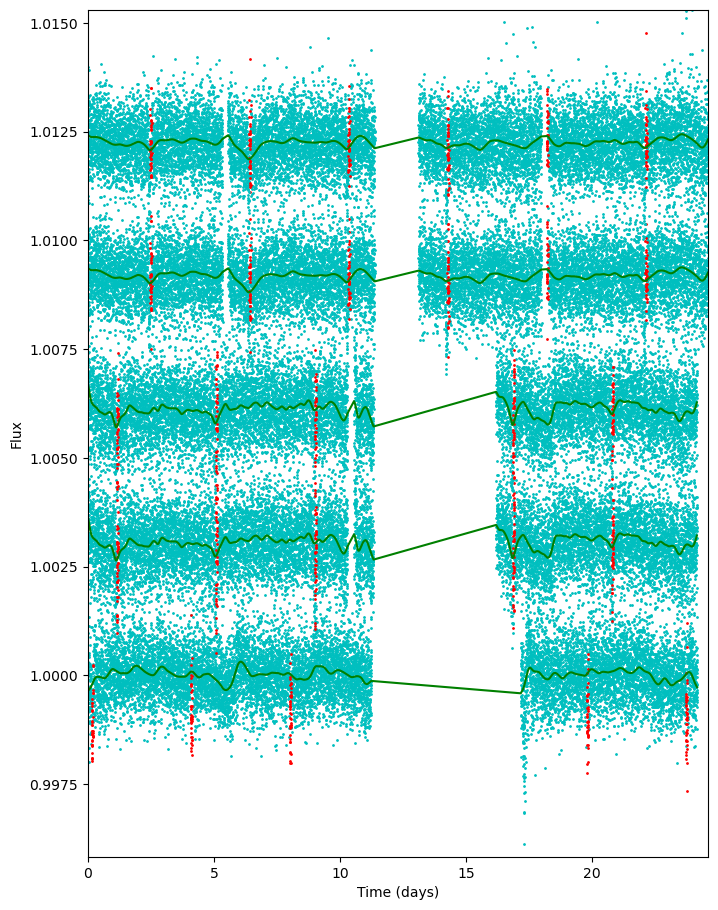

In [5]:
pwidth = transit_width(1/aR,k,b)
print('Transit width = {:0.1f} hrs'.format(pwidth*P*24))
phase = phaser(tjd, P,T0,-0.25)
flux_d = np.empty_like(flux)

fig1, ax1 = plt.subplots(figsize=(8,1+2*nsec))
offset = 5*np.nanstd(flux)
for i_sec, sec in enumerate(np.unique(sector)):
    mask = (abs(phase) > pwidth/2) & (sector == sec)
    tjd_mo = tjd[mask]
    flux_mo = flux[mask]    
    t_bin, f_bin, e_bin, n_bin = lcbin(tjd_mo, flux_mo,binwidth=1/12,nmin=8)

    Q = 1
    w0 = 1
    S0 = np.var(f_bin) / (w0 * Q)

    kernel = terms.SHOTerm(S0=S0, Q=Q, w0=w0)
    gp = celerite2.GaussianProcess(kernel, mean=1)
    gp.compute(t_bin, yerr=e_bin)  
    print("Initial log likelihood: {0}".format(gp.log_likelihood(f_bin)))

    def set_params(params, gp):
        gp.mean = params[0]
        theta = np.exp(params[1:])
        gp.kernel = terms.SHOTerm(S0=theta[0], Q=theta[1], w0=theta[2])
        return gp

    def neg_log_like(params, gp):
        gp = set_params(params, gp)
        gp.recompute(quiet=True)
        return -gp.log_likelihood(f_bin)

    initial_params = np.log([1, Q, w0, S0])
    bounds = ((-5,5),(-5, 5),(-5, 5),(-15, 15))
    soln = minimize(neg_log_like, initial_params, method="L-BFGS-B",
                    bounds=bounds,args=(gp))
    opt_gp = set_params(soln.x, gp)
    gp.recompute(quiet=True)

    
    pred_mean = gp.predict(f_bin, tjd[sector == sec],return_cov=False,return_var=False)

    ax1.scatter(tjd_mo-tjd_mo.min(),offset*i_sec+flux_mo,s=1,c='c')
    mask = (abs(phase) <= pwidth/2) & (sector == sec)
    ax1.scatter(tjd[mask]-tjd_mo.min(), offset*i_sec+flux[mask],s=1,c='r')
    mask = (sector == sec)
    ax1.plot(tjd[sector == sec]-tjd_mo.min(), offset*i_sec+pred_mean, color='g',ms=2)
    flux_d[sector == sec] = flux[sector == sec]/pred_mean

ax1.set_xlim(0,np.ptp(tjd[sector==sec]))
ax1.set_ylim(1-offset-k**2,1+nsec*offset)
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Flux');


#### Transit model

In [6]:
M = models.TransitModel()
pars = M.make_params()
pars.add('T_0', value = T0,min=T0-P/2,max=T0+P/2)
pars.add('P', value = P,min=0.99*P,max=1.01*P)
pars.add('D', value = k**2, min = 0.0001,max = 0.1)
pars.add('W', value = pwidth, min = pwidth/2,max = pwidth*2)
pars.add('b', value = b, min = 0,max = 1)
pars.add('f_c', value = 0, vary=False)  # Assume circular orbit
pars.add('f_s', value = 0, vary=False)  # Assume circular orbit
pars['h_1'] = Parameter('h_1', value = star.h_1.n, vary=False)
pars['h_2'] = Parameter('h_2', value = star.h_2.n, vary=False)
for p in pars:
    if pars[p].vary: print(pars[p])

<Parameter 'T_0', value=1517.9997, bounds=[1516.0343050000001:1519.965095]>
<Parameter 'P', value=3.93079, bounds=[3.8914821:3.9700979]>
<Parameter 'D', value=0.0011088900000000002, bounds=[0.0001:0.1]>
<Parameter 'W', value=0.014174928701777998, bounds=[0.007087464350888999:0.028349857403555997]>
<Parameter 'b', value=0.68, bounds=[0:1]>


#### Plot initial fit

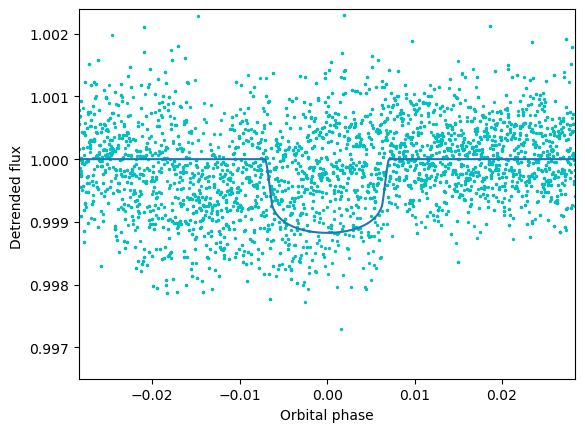

In [7]:
fig2, ax2 = plt.subplots()
ph_plot = np.linspace(-2*pwidth,2*pwidth,1001)
t_plot = T0 + ph_plot*P
f_plot = M.eval(pars,t=t_plot)
ax2.scatter(phase,flux_d,s=2,c='c')
ax2.set_xlabel('Orbital phase')
ax2.plot(ph_plot,f_plot)
ax2.set_ylabel('Detrended flux ')
ax2.set_xlim(-2*pwidth,2*pwidth)
ax2.set_ylim(1-4*flux_d.std()-k**2,1+4*flux_d.std());

#### Least-squares fit
Initial values from fit to de-trended flux

In [8]:
result_lm = M.fit(flux_d,pars,t=tjd)
print(result_lm.fit_report())

[[Model]]
    Model(_transit_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 242
    # data points      = 72692
    # variables        = 5
    chi-square         = 0.02524093
    reduced chi-square = 3.4726e-07
    Akaike info crit   = -1081158.10
    Bayesian info crit = -1081112.13
    R-squared          = 0.02888555
[[Variables]]
    T_0:  1517.99955 +/- 4.1086e-04 (0.00%) (init = 1518)
    P:    3.93060522 +/- 1.5838e-06 (0.00%) (init = 3.93079)
    D:    8.4428e-04 +/- 1.0598e-04 (12.55%) (init = 0.00110889)
    W:    0.01383130 +/- 3.3083e-04 (2.39%) (init = 0.01417493)
    b:    0.36736267 +/- 0.68187029 (185.61%) (init = 0.68)
    f_c:  0 (fixed)
    f_s:  0 (fixed)
    h_1:  0.746 (fixed)
    h_2:  0.648 (fixed)
    l_3:  0 (fixed)
    e:    0.00000000 +/- 0.00000000  == 'f_c**2 + f_s**2'
    q_1:  0.12390400 +/- 0.00000000 (0.00%) == '(1-h_2)**2'
    q_2:  0.27840909 +/- 0.00000000 (0.00%) == '(h_1-h_2)/(1-h_2)'
    k:    0.02905647 +/- 0.00

#### Plot best fit

RMS = 589 ppm


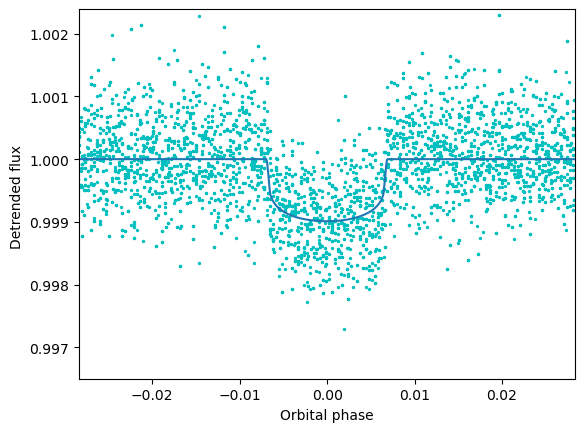

In [9]:
phase = ((((tjd - result_lm.params['T_0'])/result_lm.params['P'] % 1)+0.25) % 1) - 0.25
f_plot = M.eval(result_lm.params,t=t_plot)
resid = flux_d - M.eval(result_lm.params,t=tjd)
fig3, ax3 = plt.subplots()
ax3.scatter(phase,flux_d,s=2,c='c')
ax3.set_xlabel('Orbital phase')
ax3.plot(ph_plot,f_plot)
ax3.set_ylabel('Detrended flux ')
ax3.set_xlim(-2*pwidth,2*pwidth)
ax3.set_ylim(1-4*flux_d.std()-k**2,1+4*flux_d.std());
print('RMS = {:0.0f} ppm'.format(1e6*resid.std()))

### Sampling the posterior with emcee 
 The user_data feature of lmfit's [Parameter](https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameter) class can be used to set a ufloat values that defines a Gaussian prior on a parameter. 



In [10]:
nwalkers = 64
nburnin = 512
nsteps = 256
thin = 4

##### Prior probability distribution for D, W, b
This prior assumes uniform priors on $\cos i$, $\log k$ and $\log(a/R)$. The factor $2kW$ is the absolute value of the determinant of the Jacobian, $ J = d(D, W, b)/d(\cos i, k, a/R)$.

In [11]:
# Prior probability distribution for D, W, b
def _log_prior(D, W, b):
    if (D < 2e-6) or (D > 0.2): return -np.inf
    if (b < 0) or (b > 1): return -np.inf
    if (W < 1e-4): return -np.inf
    k = np.sqrt(D)
    aR = np.sqrt((1+k)**2 - b**2)/(np.pi*W)
    if (aR < 2): return -np.inf
    return -np.log(2*k*W) - np.log(k) - np.log(aR)

In [12]:
def log_posterior(pos, model, time, flux,  params, varnames, 
        return_fit):

    parcopy = params.copy()
    for i, p in enumerate(varnames):
        v = pos[i]
        if (v < parcopy[p].min) or (v > parcopy[p].max):
            return -np.inf
        parcopy[p].value = v
        
    fit = model.eval(parcopy, t=time)
    if return_fit:
        return fit
    if False in np.isfinite(fit):
        return -np.inf
    
    lnprior = _log_prior(parcopy['D'], parcopy['W'], parcopy['b'])
    if not np.isfinite(lnprior):
        return -np.inf
    
    # Also check parameter range here so we catch "derived" parameters
    # that are out of range.
    for p in parcopy:
        v = parcopy[p].value
        if (v < parcopy[p].min) or (v > parcopy[p].max):
            return -np.inf
        if np.isnan(v):
            return -np.inf
        u = parcopy[p].user_data
        if isinstance(u, UFloat):
            lnprior += -0.5*((u.n - v)/u.s)**2
            
    jitter = np.exp(parcopy['log_sigma'].value)
    s2 = jitter**2
    lnlike = -0.5*(np.sum((flux-fit)**2/s2 + np.log(2*np.pi*s2)))
    return lnlike + lnprior



In [13]:
params = result_lm.params.copy()
lnrms = np.log(resid.std())
params.add('log_sigma',value=lnrms,min=lnrms-5,max=lnrms+5)
vv = []
vs = []
vn = []
for p in params:
    if params[p].vary:
        vn.append(p)
        vv.append(params[p].value)
        if params[p].stderr is None:
            vs.append(0.01*(params[p].max-params[p].min))
        else:
            vs.append(params[p].stderr)           

init_scale = 0.1  # use this fraction of standard error to spread walker positions  
args=(M, tjd, flux_d,  params, vn, False)
pos = []
n_varys = len(vn)
for i in range(nwalkers):
    params_tmp = params.copy()
    lnlike_i = -np.inf
    while lnlike_i == -np.inf:
        pos_i = vv + vs*np.random.randn(n_varys)*init_scale
        lnlike_i = log_posterior(pos_i, *args)
    pos.append(pos_i)


#### Run the sampler

In [14]:
sampler = EnsembleSampler(nwalkers, n_varys, log_posterior,args=args)
print('Running burn-in ...')
pos, _, _ = sampler.run_mcmc(pos, nburnin, store=False, 
                             skip_initial_state_check=True, progress=True)
sampler.reset()
print('Running sampler ...')
state = sampler.run_mcmc(pos, nsteps, thin_by=thin, 
                         skip_initial_state_check=True, progress=True)

Running burn-in ...


100%|██████████| 512/512 [02:14<00:00,  3.81it/s]


Running sampler ...


100%|██████████| 1024/1024 [05:27<00:00,  3.13it/s]


#### Plot parameter v. step number to check for convergence

Only plotting selected parameters here.

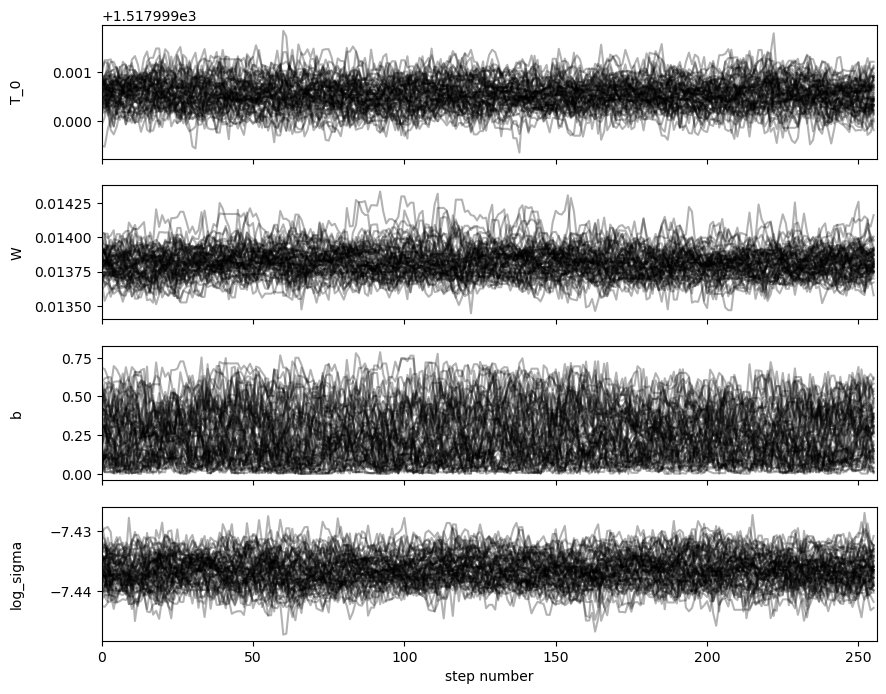

In [15]:
fig9, ax9 = plt.subplots(4, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
for i,p in enumerate(["T_0", "W", 'b', "log_sigma"]):
    ax = ax9[i]
    j = vn.index(p)
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(p)
    ax.yaxis.set_label_coords(-0.1, 0.5)
ax9[-1].set_xlabel("step number");

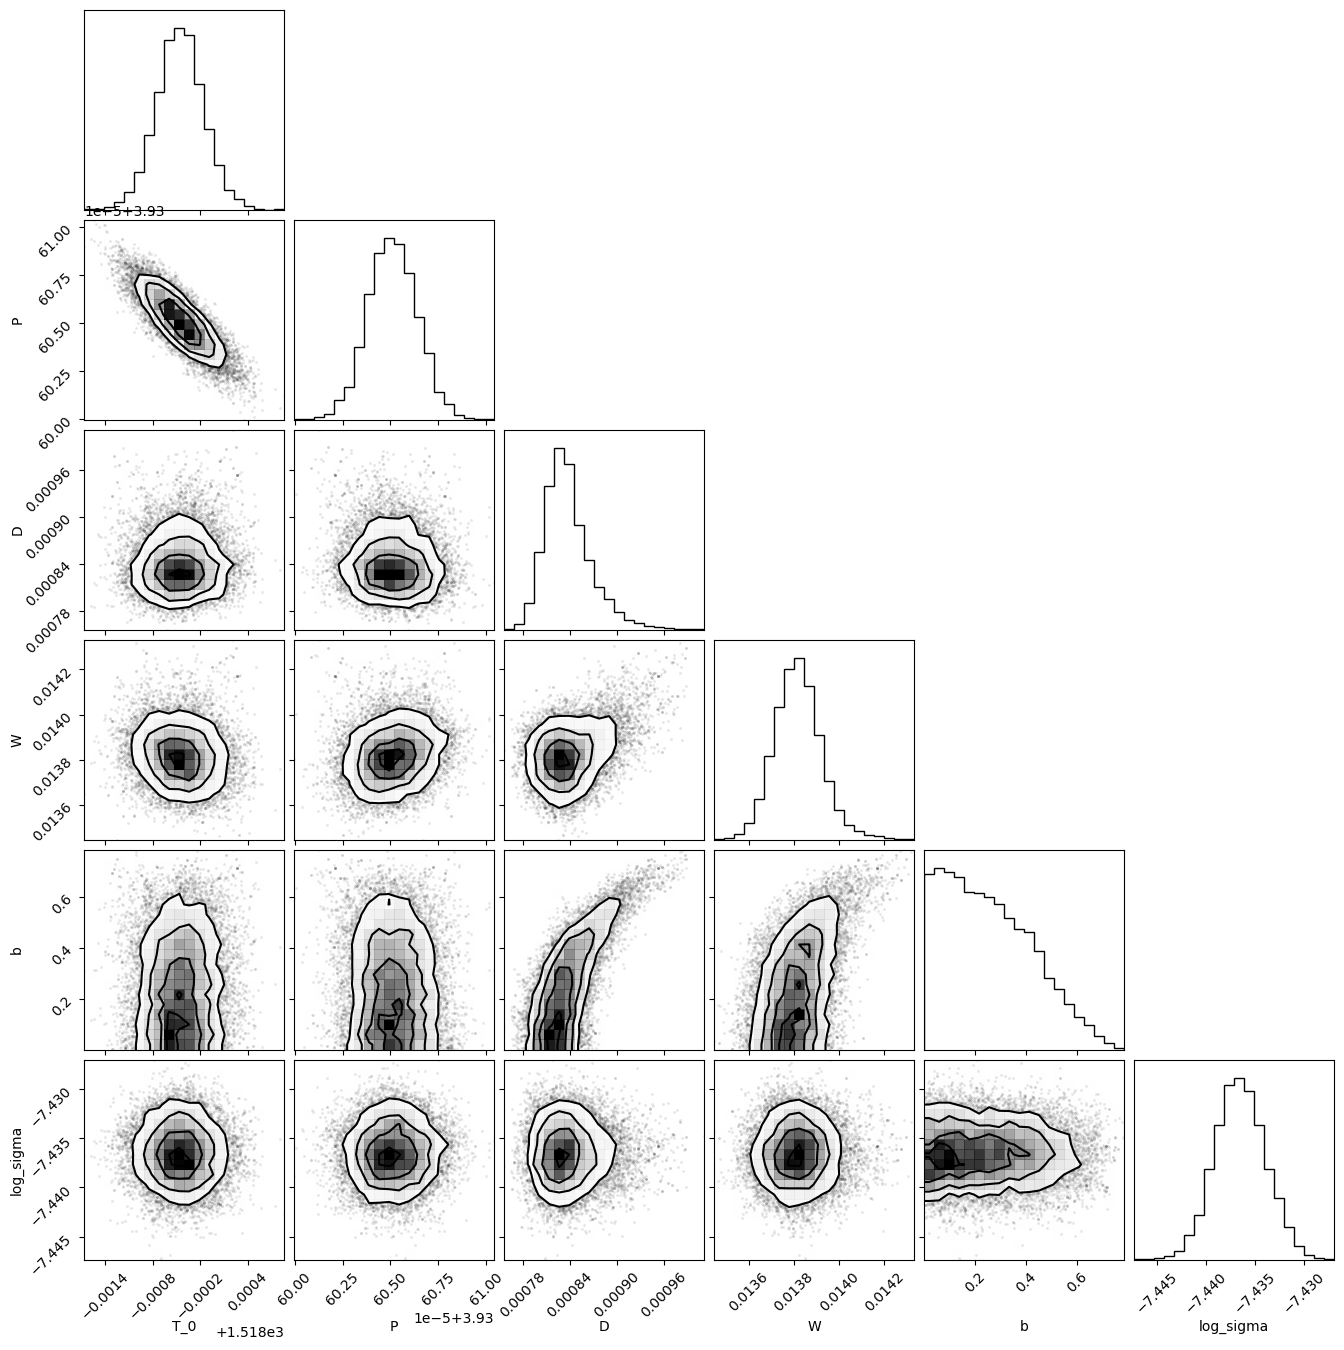

In [16]:
import corner
flat_samples = sampler.get_chain(flat=True)
fig = corner.corner(flat_samples, labels=vn);

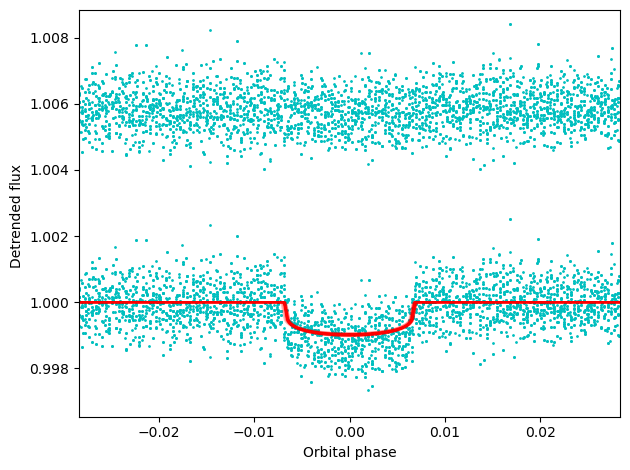

In [17]:
pos = flat_samples[np.argmax(sampler.flatlnprobability),:]
phase = ((((tjd - pos[vn.index('T_0')])/pos[vn.index('P')] % 1)+0.25) % 1) - 0.25
fit = log_posterior(pos, M, tjd, flux,  params, vn,
        return_fit=True)
rms = (flux_d-fit).std()

fig4, ax4 = plt.subplots()
t_plot = pos[vn.index('T_0')] + ph_plot*pos[vn.index('P')]
f_plot = log_posterior(pos, M, t_plot, flux,  params, vn,
        return_fit=True)
ax4.scatter(phase,flux,s=1,c='c')
ax4.scatter(phase,flux-fit+1+10*rms,s=1,c='c')
ax4.set_xlabel('Orbital phase')
ax4.plot(ph_plot,f_plot,c='r')

nsamples = 64
for i in np.linspace(0,nsteps,nsamples,endpoint=False,dtype=int):
    pos = flat_samples[i,:]
    f_plot = log_posterior(pos, M, t_plot, flux,  params, vn,
        return_fit=True)
    ax4.plot(ph_plot,f_plot,c='r',alpha=0.1)

ax4.set_ylabel('Detrended flux ')
ax4.set_xlim(-2*pwidth,2*pwidth)
ax4.set_ylim(1-4*rms-k**2,1+15*rms);

fig4.tight_layout();


In [18]:
for i,n in enumerate(vn):
    print("{:4s} = {:0.5f} +/- {:0.5f}".format(n,flat_samples[:,i].mean(),flat_samples[:,i].std()))
print('RMS = {:0.0f} ppm'.format(1e6*rms))


T_0  = 1517.99955 +/- 0.00030
P    = 3.93061 +/- 0.00000
D    = 0.00084 +/- 0.00003
W    = 0.01382 +/- 0.00010
b    = 0.25634 +/- 0.17050
log_sigma = -7.43652 +/- 0.00257
RMS = 589 ppm


#### Observing window for future transits

In [19]:
Pmiss = 1  # Percentage probability to miss eclipse
obs_date = Time('2020-12-31T00:00:00')
cycle = round((obs_date.jd-2457000-T0)/P)
print('Cycle number = {:0.0f}'.format(cycle))
t = cycle*flat_samples[:,vn.index('P')] + flat_samples[:,vn.index('T_0')]
print('TJD mid-transit = {:0.5f} +/- {:0.5f}'.format(t.mean(),t.std()))
print('{}-% observing window = {:0.5f} - {:0.5f}'.format(100-Pmiss,*np.percentile(t,(Pmiss/2,100-Pmiss/2))))

Cycle number = 177
TJD mid-transit = 2213.71665 +/- 0.00017
99-% observing window = 2213.71622 - 2213.71709


#### Planet mass and radius
Stellar parameters and semi-amplitude of rv signal from Luque et al., [2019A&A...628A..39L](http://simbad.u-strasbg.fr/simbad/sim-ref?bibcode=2019A%26A...628A..39L)

- $M_{\star} =  0.342 \pm 0.011\,M_{\odot}$ Schweitzer et al. (2019)
- $R_{\star} =  0.337 \pm 0.015\,R_{\odot}$ Schweitzer et al. (2019)
- $K = 1.52 \pm 0.25$ m/s

    m_star   =      0.342 +/-      0.011 (    -0.011,    +0.011) M_Sun
    r_star   =      0.337 +/-      0.015 (    -0.015,    +0.015) R_Sun
    e        =       0.00 +/-       0.00 (     -0.00,     +0.00)
    r_p      =      1.064 +/-      0.051 (    -0.050,    +0.052) R_Earth
    m_p      =       1.83 +/-       0.30 (     -0.31,     +0.30) M_Earth
    q        =  0.0000161 +/-  0.0000027 (-0.0000027,+0.0000027)
    a        =      7.330 +/-      0.078 (    -0.079,    +0.077) R_Sun
    a        =    0.03409 +/-    0.00036 (  -0.00037,  +0.00036) au
    rho_star =       10.7 +/-        1.6 (      -2.3,      +0.9) rho_Sun
    g_p      =       17.3 +/-        3.8 (      -3.9,      +3.7) m.s-2
    log g_p  =      3.239 +/-      0.097 (    -0.110,    +0.083) [cgs]
    rho_p    =       1.76 +/-       0.45 (     -0.48,     +0.43) rho_Earth
    rho_p    =        9.7 +/-        2.5 (      -2.7,      +2.4) [g.cm-3]


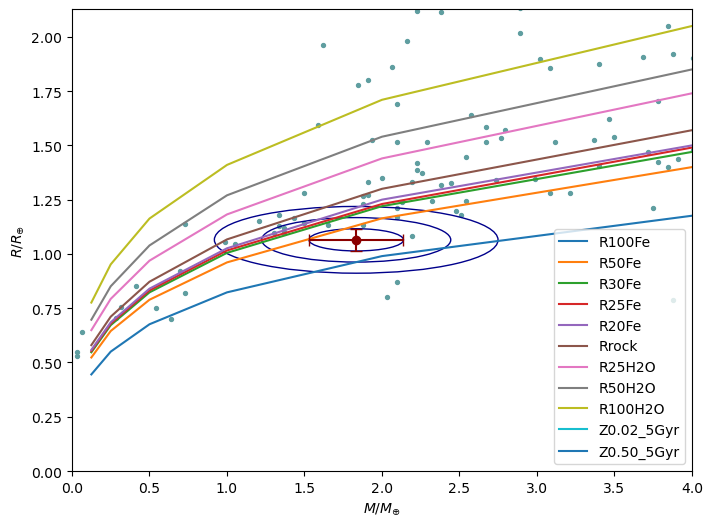

In [20]:
from pycheops.funcs import massradius, rhostar

k = np.sqrt(flat_samples[:,vn.index('D')])
b = flat_samples[:,vn.index('b')]
W = flat_samples[:,vn.index('W')]
aR = np.sqrt((1+k)**2-b**2)/W/np.pi
sini = np.sqrt(1 - (b/aR)**2)
rho_star = rhostar(1/aR,P)
massradius
m_star = (0.342, 0.011)
r_star = (0.337, 0.015)
res,fig =massradius(m_star=m_star, r_star=r_star, 
                    k=k, aR=aR, sini=sini, 
                    P=P, K=(1.52, 0.25),
                    zeng_models='all', xlim=(0,4))

&copy; Pierre Maxted, Keele University (2024)